# **TACO Trash -	[taco-trash-dataset](https://www.kaggle.com/datasets/kneroma/tacotrashdataset)**

### Tipo de problema : Detección
- objetivo detección de residuos: Utilizar imágenes para identificar la presencia de residuos. Este modelo puede ser útil para planificar limpiar y preservar estos espacios.​
- Entrenar un modelo para identificar la presencia de residuos plásticos en imágenes.

# Integrantes
|N° SIU| NOMBRE APELLIDO--------------| CORREO---------------------|
|-----|-------------------------------|----------------------------|
|a1904|	Marck Anthony Murillo Ronquillo| murillo.ronq.50c2@gmail.com|
|a1906|	Yandri Jair	Uchuari Gallardo| yandriuchuari@gmail.com|
|a1823|	Luis Alberto Santamaria Jimenez| santamaria.luigi@gmail.com|

# Modelo para la deteccipon TACO Trash

### Porque yolo 

El dataset de taco-trash posee un conjunto de datos muy particulares donde se enfoca en detectar basura en entornos urbanos, donde tenemos una gran variedad de paisajes urbano y semi urbano sonde se entremezclan gran variedad de objetos que no podemos definir basura ejemplo hojas en el suelo de un parque y entre ellas se encuentra un vaso de plástico desechable. Muchos objetos por el cual diferenciar y detectar. 

YOLO está diseñado para detección rápida y de alta precisión de objetos, detectando y diferenciando múltiples clases de objetos. También es un modelo pre-entrenado y con una curva de aprendizaje rápida. 



In [ ]:
# DEscarga del DataSet 
# # Descargamos archivos y descomprimimos 
!pip install gdown
# https://drive.google.com/file/d/1ORFJYbu2-O30vm609xddWSBZjvGvaYE9/view?usp=sharing
!gdown https://drive.google.com/uc?id=1ORFJYbu2-O30vm609xddWSBZjvGvaYE9 -O archive.zip


In [ ]:
!unzip archive.zip -d taco_trash_dataset

In [ ]:
!pip install pycocotools


In [ ]:
import os
import shutil
import numpy as np
import tqdm
from pycocotools.coco import COCO
data_source = COCO(annotation_file='/home/ose/Documents/Proyecto Yandri CEIA/taco_trash_dataset/data/annotations.json')

El dataset original tenemos 60 categorías, pero el proyecto de entrenamiento son enfoca solo en algunas. Por medio del siguiente diccionario, `label_transfer`, definimos un "mapa de traducción". Convierte los IDs de las clases originales que interesan (ej. el ID 5 que corresponde a 'Clear plastic bottle') a un nuevo conjunto de IDs que empiezan en 0 (ej. 0). esto es un requisito para entrenar modelos YOLO ya que el formato del dataset esta en formato coco. 


In [ ]:
# remapping label id to 0~1

# 'Clear plastic bottle': 5  -> 0
# 'Plastic bottle cap': 7 -> 1
# 'Drink can': 12 -> 2
# 'Other plastic': 29 -> 3
# 'Plastic film': 36 -> 4
# 'Other plastic wrapper': 39 -> 5
# 'Unlabeled litter': 58 -> 6
# 'Cigarette': 59 -> 7
label_transfer = {5: 0,
                  7: 1,
                  12: 2,
                  29: 3,
                  36: 4,
                  39: 5,
                  58: 6}


In [ ]:
img_ids = data_source.getImgIds()

catIds = data_source.getCatIds()
categories = data_source.loadCats(catIds)
categories.sort(key=lambda x: x['id'])
classes = {}
coco_labels = {}
coco_labels_inverse = {}
for c in categories:
    coco_labels[len(classes)] = c['id']
    coco_labels_inverse[c['id']] = len(classes)
    classes[c['name']] = len(classes)

class_num = {}

 Creamos la estructura de carpetas (tmp/images y tmp/labels) donde se guardarán temporalmente las imágenes y sus etiquetas ya convertidas al formato YOLO.

In [ ]:
!mkdir -p tmp/labels tmp/images
save_base_path  = 'tmp/labels/'
save_image_path = 'tmp/images/'

Convertimos las coordenadas de las cajas delimitadoras (bounding boxes) del formato COCO ([x_min, y_min, width, height]) al formato YOLO (<class_id> <x_center_norm> <y_center_norm> <width_norm> <height_norm>), donde los valores están normalizados entre 0 y 1. Guardando estas anotaciones en un archivo .txt por cada imagen.

In [ ]:
for index, img_id in tqdm.tqdm(enumerate(img_ids), desc='change .json file to .txt file'):
    img_info = data_source.loadImgs(img_id)[0]

    save_name = img_info['file_name'].replace('/', '_')

    file_name = save_name.split('.')[0]

    height = img_info['height']
    width = img_info['width']

    save_path = save_base_path + file_name + '.txt'
    is_exist = False
    with open(save_path, mode='w') as fp:

        annotation_id = data_source.getAnnIds(img_id)
        boxes = np.zeros((0, 5))
        if len(annotation_id) == 0:
            fp.write('')
            continue

        annotations = data_source.loadAnns(annotation_id)
        lines = ''

        for annotation in annotations:

            label = coco_labels_inverse[annotation['category_id']]
            if label in label_transfer.keys():

                is_exist = True
                box = annotation['bbox']
                if box[2] < 1 or box[3] < 1:

                    continue

                box[0] = round((box[0] + box[2] / 2) / width, 6)
                box[1] = round((box[1] + box[3] / 2) / height, 6)
                box[2] = round(box[2] / width, 6)
                box[3] = round(box[3] / height, 6)
                label = label_transfer[label]
                if label not in class_num.keys():
                    class_num[label] = 0
                class_num[label] += 1
                lines = lines + str(label)
                for i in box:
                    lines += ' ' + str(i)
                lines += '\n'
        fp.writelines(lines)
    if is_exist:

        shutil.copy('/home/ose/Documents/Proyecto Yandri CEIA/taco_trash_dataset/data/{}'.format(img_info['file_name']), os.path.join(save_image_path, save_name))
    else:

        os.remove(save_path)

In [ ]:
# herramineta para guarda estas anotaciones en un archivo .txt por cada imagen.
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio('tmp', output="taco/", seed=1337, ratio=(.8, 0.1,0.1))

In [ ]:
# Entrenamiento con YOLOv11
from ultralytics import YOLO

# Cargar modelo YOLOv11 preentrenado
model = YOLO("best.pt")  # Puedes usar yolov11s.pt o yolov11m.pt según recursos

# Entrenar
model.train(data="taco_trash.yaml", epochs=50, imgsz=1234, batch=32, device='0', optimizer = "AdamW", seed=0)

# Evaluar (opcional)
model.val()

In [ ]:
# Entrenamiento con YOLOv11
from ultralytics import YOLO

# Define configuración / hiperparámetros en un diccionario
config = {
    "data": "taco_trash.yaml",
    "epochs": 150,
    "batch": 8,
    "patience": 60,
    "warmup_epochs": 10,
  
    "save_period": 2,
    "iou": 0.25,
    "lr0": 0.01,
    "lrf": 0.000001,
    "imgsz": 1536,  # Ajusta según tus necesidades
    "plots": True,
}


# Carga modelo
model = YOLO("best.pt")

# Entrena usando parámetros de config
model.train(
    data=config["data"],
    epochs=config["epochs"],
    batch=config["batch"],
    patience=config["patience"],
    warmup_epochs=config["warmup_epochs"],
    save_period=config["save_period"],
    imgsz= config["imgsz"],
    lr0=config["lr0"],
    lrf=config["lrf"],
    plots=config["plots"],
    conf = 0.6,  # Ajusta según tus necesidades
    weight_decay= 0.0005,
    device='0',  # Especifica el dispositivo GPU a usar
    optimizer="AdamW",
    augment=True,
    multi_scale=True,
    seed=0,
    cos_lr=True,   
    val = True, 

    
    
)




In [ ]:
from ultralytics import YOLO
model = YOLO("best.pt")  # mejor partir de COCO preentrenado; evita reusar 'best.pt'

model.train(
    data="taco_trash.yaml",
    epochs=120,
    imgsz=1536,              # luego haremos FT a 1280/1536
    batch=8,
    
    optimizer="AdamW",
    lr0=3e-4,
    lrf=1e-3,
    weight_decay=0.01,
    warmup_epochs=3,
    cos_lr=True,
    

    # NMS/umbral
    iou=0.60,                # NMS más estricto
    conf=0.5,

    # Augmentations pro-small
    mosaic=1.0,
    copy_paste=0.5,
    mixup=0.1,
    erasing=0.4,
    scale=0.5,
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    perspective=0.0, shear=0.0,
    multi_scale=True,

    # Pérdidas
    box=10.0, dfl=1.5,
    label_smoothing=0.05,
    

    patience=80,
    save_period=5,
    plots=True,
    device=0,
    seed=0,
)



# Métricas durante el entrenamiento en yolo 

### Métricas de Progreso del Entrenamiento
En la primera fila donde se informa las épocas de entrenamiento se proporcionando información en  tiempo real del progreso del modelo.

-  Epoch: El número de la época actual. Una época es un ciclo completo en el que el modelo ha visto todo el conjunto de datos de entrenamiento una vez.
-  GPU_mem: La cantidad de memoria de la GPU (en GB) que está utilizando el modelo en ese momento. Es útil para monitorear el uso de recursos.
-  box_loss: El valor de la pérdida de la caja delimitadora. Mide la precisión con la que el modelo predice la ubicación y el tamaño de las cajas que rodean los objetos. Un valor más bajo indica una mejor precisión en la localización de los objetos.
-  cls_loss: El valor de la pérdida de la clasificación. Mide la precisión con la que el modelo predice la clase correcta de los objetos. Un valor más bajo indica que el modelo está clasificando mejor los objetos.
-  dfl_loss (Distribution Focal Loss): Una métrica de pérdida adicional que ayuda a refinar la predicción de la caja delimitadora. Mide la calidad de la distribución de las coordenadas. Un valor más bajo indica una predicción más precisa.
-  Instances: El número de instancias (objetos) que el modelo ha detectado en el lote de entrenamiento actual.
-  Size: El tamaño de las imágenes que se están procesando en el lote actual (por ejemplo, 640 o 1280).
-  it/s: El número de iteraciones por segundo. Es una medida de la velocidad de entrenamiento del modelo.

###  Métricas de Evaluación
En la segunda fila: se ejecuta periódicamente para evaluar el rendimiento del modelo en un conjunto de datos que no ha visto durante el entrenamiento.
-  Class: El nombre de la clase de objeto que se está evaluando. Si el modelo se está evaluando en su conjunto, verás all.
-  Images: El número de imágenes en el conjunto de datos de validación.
-  Instances: El número total de objetos en el conjunto de datos de validación.
-  Box(P, R, mAP50, mAP50-95): Estas son las métricas de rendimiento más relevantes para la detección de objetos.
-	P (Precision): La precisión de la detección. Es la proporción de predicciones positivas correctas (verdaderos positivos) con respecto al total de predicciones positivas (verdaderos positivos + falsos positivos).
-	R (Recall): La sensibilidad o exhaustividad de la detección. Es la proporción de predicciones positivas correctas con respecto al total de objetos que realmente existen en el conjunto de datos (verdaderos positivos + falsos negativos).
-	mAP50 (mean Average Precision at 50% IoU): La precisión media promedio con un umbral de superposición de 50% (IoU - Intersection over Union). Es la métrica más común para evaluar modelos de detección de objetos.
-	mAP50-95 (mean Average Precision over different IoU thresholds): La precisión media promedio calculada en un rango de umbrales de IoU, desde 50% hasta 95% en incrementos de 5%. Es una métrica más estricta que da una visión más completa del rendimiento del modelo.



### Métrica de pérdida (Loss)
Las métricas de pérdida (loss) indican qué tan bien se está ajustando el modelo a los datos de entrenamiento. Un valor más bajo es mejor, ya que significa que la diferencia entre las predicciones del modelo y la realidad es menor.
- **`box_loss` (pérdida de la caja de delimitación):** Mide la precisión de las cajas que el modelo predice para rodear los objetos.
    - **Valor alto:** El modelo está prediciendo cajas de delimitación incorrectas. Las cajas están mal posicionadas, son del tamaño equivocado o no coinciden bien con los objetos reales.
    - **Valor bajo:** Las cajas de delimitación predichas por el modelo son precisas y se ajustan bien a los objetos.
- **`cls_loss` (pérdida de la clasificación):** Mide la precisión de la clasificación de los objetos dentro de las cajas.
    - **Valor alto:** El modelo está clasificando incorrectamente los objetos. Por ejemplo, confunde a un perro con un gato.
    - **Valor bajo:** El modelo está clasificando correctamente los objetos en sus respectivas clases.
- **`dfl_loss` (pérdida de la distribución de características):** Esta es una métrica específica de YOLOv8 que mejora la precisión de la caja de delimitación al predecir la distribución de las características.
    - **Valor alto:** El modelo tiene dificultades para predecir la distribución de las características, lo que puede resultar en cajas de delimitación menos precisas.
    - **Valor bajo:** El modelo está aprendiendo de manera efectiva la distribución de características, lo que conduce a una mayor precisión en las cajas de delimitación.


### Métricas de rendimiento
Estas métricas evalúan el rendimiento del modelo en el conjunto de validación o de prueba y nos indican la calidad de las predicciones en términos de precisión y exhaustividad.
- **`Box(P, R, mAP50, mAP50-95)`:** Se refiere a las métricas de **Precisión (P)**, **Exhaustividad (R)** y **mAP** (mean Average Precision).
    - **`P` (Precision):** La proporción de predicciones correctas de un objeto.
        - **Valor alto (cercano a 1):** El modelo tiene muy pocos falsos positivos. Cuando predice un objeto, es muy probable que sea el objeto correcto.
        - **Valor bajo (cercano a 0):** El modelo tiene muchos falsos positivos. Cuando predice un objeto, puede que en realidad no exista o que sea de una clase incorrecta.
    - **`R` (Recall o Exhaustividad):** La proporción de objetos reales que el modelo logró detectar.
        - **Valor alto (cercano a 1):** El modelo es muy bueno detectando todos los objetos que existen en la imagen. No deja muchos objetos sin detectar (falsos negativos).
        - **Valor bajo (cercano a 0):** El modelo no logra detectar muchos de los objetos reales en la imagen.
    - **`mAP50`:** **mean Average Precision (promedio de precisión) con un IoU (Intersection over Union) de 0.5.** Es la métrica más importante y comúnmente usada.
        - **Buena métrica:** Un valor **alto** (idealmente por encima de 0.8) indica que el modelo es preciso y exhaustivo en la detección, con un umbral de superposición de la caja de 50%.
        - **Mala métrica:** Un valor **bajo** (por debajo de 0.5) indica que el rendimiento del modelo es deficiente.
    - **`mAP50-95`:** Es el promedio del mAP calculado en varios umbrales de IoU, desde 0.50 hasta 0.95, con un paso de 0.05.
        - **Buena métrica:** Un valor **alto** (por encima de 0.5) indica que el modelo no solo detecta los objetos correctamente, sino que también sus cajas de delimitación son **extremadamente precisas**. Es una métrica más estricta que `mAP50`.
        - **Mala métrica:** Un valor **bajo** indica que las cajas de delimitación del modelo no se ajustan bien a los objetos, incluso si la detección inicial es correcta.

In [8]:
# Fine-tuning de resolución (últimas 60 épocas aproximadamente)
model.train(
    data="taco_trash.yaml",
    epochs=150,
    imgsz=1536,              
    lr0=1.5e-4,
    lrf=5e-4,
    model = "best.pt"
)

      1/150      21.5G      1.277      1.487      1.119          5       1920: 100%|██████████| 207/207 [00:46<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.89it/s]

                   all         72         97      0.483      0.386      0.439      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      21.5G      1.103      1.165      1.057          4       1248: 100%|██████████| 207/207 [00:45<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.84it/s]

                   all         72         97      0.652      0.347      0.495      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      18.3G     0.9931     0.9938      1.013          2        928: 100%|██████████| 207/207 [00:43<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

                   all         72         97      0.589      0.426      0.553        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      15.7G     0.9956     0.9972      1.024          0       1600: 100%|██████████| 207/207 [00:42<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.87it/s]

                   all         72         97      0.693       0.41      0.556      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      17.4G      1.007     0.9771      1.022          2       1184: 100%|██████████| 207/207 [00:45<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.55it/s]

                   all         72         97      0.672       0.38      0.533      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      21.9G      1.022     0.9452      1.032          1        896: 100%|██████████| 207/207 [00:44<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.90it/s]

                   all         72         97      0.622      0.396      0.529      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      17.7G      1.006     0.9975      1.037          1       1312: 100%|██████████| 207/207 [00:44<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.19it/s]

                   all         72         97      0.625       0.38       0.51      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      17.9G     0.9575      0.954      1.007          0       1952: 100%|██████████| 207/207 [00:45<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.43it/s]

                   all         72         97      0.533      0.408      0.492      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      16.5G     0.9436     0.8614          1          2       1824: 100%|██████████| 207/207 [00:43<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


                   all         72         97      0.569      0.419      0.535      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      16.5G     0.9484     0.9174      1.014          0       1344: 100%|██████████| 207/207 [00:43<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.52it/s]

                   all         72         97      0.532      0.413      0.504       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      18.5G     0.9503     0.8843      1.009          0       1472: 100%|██████████| 207/207 [00:45<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.07it/s]

                   all         72         97      0.616      0.379      0.525      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      17.9G     0.9236     0.8209       1.01          1       1600: 100%|██████████| 207/207 [00:42<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.54it/s]

                   all         72         97      0.701      0.371      0.528      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150        20G     0.9312     0.8971      1.007          3        896: 100%|██████████| 207/207 [00:44<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


                   all         72         97      0.571       0.46      0.563      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      15.9G     0.9077     0.8102     0.9886          7       2144: 100%|██████████| 207/207 [00:43<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.40it/s]

                   all         72         97      0.595      0.417      0.546      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      21.2G     0.9128     0.8135     0.9867          1       1984: 100%|██████████| 207/207 [00:45<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.53it/s]


                   all         72         97      0.516       0.43      0.515      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      17.6G     0.9384     0.9157     0.9846          2       1088: 100%|██████████| 207/207 [00:44<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.80it/s]

                   all         72         97      0.659      0.398       0.53      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      21.2G     0.9559     0.8765      1.028          3       1024: 100%|██████████| 207/207 [00:44<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.99it/s]

                   all         72         97      0.534      0.469      0.537      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      16.9G     0.8941     0.7862     0.9712          1        832: 100%|██████████| 207/207 [00:45<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.79it/s]

                   all         72         97      0.584      0.405      0.519      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      22.3G     0.9539     0.9096      1.005          3       2240: 100%|██████████| 207/207 [00:44<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.86it/s]

                   all         72         97      0.556      0.443      0.533      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150        17G     0.9081      0.829     0.9925          5       1344: 100%|██████████| 207/207 [00:44<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.39it/s]

                   all         72         97      0.726      0.394      0.542        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      18.7G     0.8762      0.768     0.9738          4       2176: 100%|██████████| 207/207 [00:43<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.80it/s]

                   all         72         97      0.801      0.374      0.549      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      21.2G     0.9367     0.8792      0.987          2       1760: 100%|██████████| 207/207 [00:45<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.45it/s]

                   all         72         97      0.562      0.432      0.532      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150        17G     0.9308     0.8534      1.006          1       1568: 100%|██████████| 207/207 [00:43<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.87it/s]

                   all         72         97      0.498      0.431       0.52      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      17.7G     0.9018     0.7836     0.9927          5        992: 100%|██████████| 207/207 [00:44<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.97it/s]

                   all         72         97      0.531      0.451      0.536      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      17.3G     0.8491     0.7331      0.966          3       1920: 100%|██████████| 207/207 [00:42<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.98it/s]

                   all         72         97      0.531      0.443      0.533       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      18.1G     0.8953     0.8072     0.9625          0       2112: 100%|██████████| 207/207 [00:43<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.93it/s]

                   all         72         97      0.567      0.409      0.519      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      21.2G     0.8928     0.7805     0.9822          4       1408: 100%|██████████| 207/207 [00:43<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.77it/s]

                   all         72         97      0.586        0.4      0.522      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      17.2G     0.9411      0.851     0.9801          3       1280: 100%|██████████| 207/207 [00:45<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.05it/s]

                   all         72         97      0.673      0.366      0.521      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      21.3G     0.9131      0.837     0.9971          2       2048: 100%|██████████| 207/207 [00:42<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.00it/s]

                   all         72         97      0.544      0.399       0.51      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      20.4G     0.9221     0.8051     0.9855          1       1984: 100%|██████████| 207/207 [00:43<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.08it/s]

                   all         72         97      0.592      0.409      0.522      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      21.2G     0.8934     0.8093     0.9754          1        832: 100%|██████████| 207/207 [00:42<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.92it/s]

                   all         72         97      0.508      0.463      0.524      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      17.3G     0.8703     0.7296     0.9746          1       2144: 100%|██████████| 207/207 [00:42<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

                   all         72         97      0.668      0.344      0.511      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      17.3G      0.907     0.8216     0.9861          0       1152: 100%|██████████| 207/207 [00:44<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.94it/s]

                   all         72         97      0.643      0.385      0.511       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      17.7G     0.8878     0.8244      0.971          2        864: 100%|██████████| 207/207 [00:44<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.20it/s]

                   all         72         97      0.444      0.399      0.471      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      17.3G      0.912     0.8116     0.9793         16       1856: 100%|██████████| 207/207 [00:43<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.20it/s]

                   all         72         97      0.546      0.417      0.533      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      21.9G     0.8815     0.7987     0.9694          2        992: 100%|██████████| 207/207 [00:44<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.59it/s]

                   all         72         97      0.623      0.391      0.527      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      16.3G     0.8905     0.7442      1.001          3       1856: 100%|██████████| 207/207 [00:43<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.31it/s]

                   all         72         97      0.684      0.358      0.509      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      16.9G     0.8562     0.7537     0.9625          2        960: 100%|██████████| 207/207 [00:45<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.17it/s]

                   all         72         97      0.494      0.451      0.524      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      17.6G      0.909     0.8052     0.9771          2       1408: 100%|██████████| 207/207 [00:43<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


                   all         72         97      0.492      0.413      0.504      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      20.2G     0.9477      0.874     0.9947          1        992: 100%|██████████| 207/207 [00:43<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

                   all         72         97      0.562      0.418      0.527      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      21.1G     0.8884     0.7665     0.9804          2       1312: 100%|██████████| 207/207 [00:42<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.66it/s]

                   all         72         97      0.741      0.383      0.529      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      16.5G     0.8738     0.7668     0.9827          4       1248: 100%|██████████| 207/207 [00:43<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.25it/s]

                   all         72         97      0.632       0.38      0.515      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      20.5G     0.9055     0.8261     0.9727          2       1888: 100%|██████████| 207/207 [00:41<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


                   all         72         97      0.537      0.409      0.511      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      17.2G      0.868     0.7833     0.9669          2       1312: 100%|██████████| 207/207 [00:44<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.18it/s]

                   all         72         97       0.57       0.43      0.532      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150        17G     0.8438     0.7761     0.9535          1        960: 100%|██████████| 207/207 [00:42<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


                   all         72         97      0.563      0.433      0.534      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150        17G     0.8721     0.7793     0.9763          2       2208: 100%|██████████| 207/207 [00:44<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.89it/s]

                   all         72         97      0.587      0.414      0.528      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      17.1G      0.911     0.7535     0.9914          3       1472: 100%|██████████| 207/207 [00:42<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.98it/s]

                   all         72         97      0.525      0.421      0.521      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      16.9G     0.9173     0.8175     0.9813          4       2080: 100%|██████████| 207/207 [00:43<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.15it/s]

                   all         72         97      0.604      0.407      0.519      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      16.5G     0.9103     0.8318     0.9744          2       1312: 100%|██████████| 207/207 [00:45<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

                   all         72         97       0.67      0.361      0.518      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150        17G     0.9324      0.834     0.9922          0       1696: 100%|██████████| 207/207 [00:43<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.20it/s]

                   all         72         97       0.63      0.399      0.544      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      18.7G     0.9334      0.813      1.013          2       1792: 100%|██████████| 207/207 [00:45<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.26it/s]

                   all         72         97       0.54      0.448       0.54      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      17.1G     0.9267     0.8535     0.9881          3       2112: 100%|██████████| 207/207 [00:43<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.04it/s]

                   all         72         97      0.643      0.378      0.516      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      21.8G     0.8998     0.7983     0.9681          7       1888: 100%|██████████| 207/207 [00:43<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.78it/s]

                   all         72         97      0.703       0.39      0.538      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      21.5G     0.9095     0.8676      1.001          8       1952: 100%|██████████| 207/207 [00:45<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

                   all         72         97      0.621      0.409      0.531      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      20.4G     0.9362     0.8933      1.002          6       1344: 100%|██████████| 207/207 [00:44<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.59it/s]

                   all         72         97      0.529      0.431      0.524      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      22.2G     0.8579     0.7864     0.9523          0       1088: 100%|██████████| 207/207 [00:41<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.88it/s]

                   all         72         97      0.566      0.421      0.528      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      17.1G     0.9042     0.8303     0.9853          4       1664: 100%|██████████| 207/207 [00:43<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

                   all         72         97      0.678      0.339      0.501      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150        18G     0.9624      0.877      1.008          5       1504: 100%|██████████| 207/207 [00:43<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.93it/s]

                   all         72         97      0.554      0.396       0.49      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      21.2G     0.9219     0.8128      0.998          5        896: 100%|██████████| 207/207 [00:44<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.29it/s]

                   all         72         97      0.574      0.387      0.507      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      16.4G     0.9092     0.8417      0.986          0       1120: 100%|██████████| 207/207 [00:46<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.76it/s]

                   all         72         97      0.669      0.363      0.513      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150        22G     0.8839     0.7934     0.9758          2        800: 100%|██████████| 207/207 [00:41<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.76it/s]


                   all         72         97      0.667      0.346      0.504      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      17.3G     0.8611     0.8069     0.9672          0       1344: 100%|██████████| 207/207 [00:43<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.92it/s]

                   all         72         97      0.599      0.358      0.498      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      17.7G     0.9134     0.7959      1.005          2       2112: 100%|██████████| 207/207 [00:45<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.90it/s]

                   all         72         97      0.606      0.363      0.511      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      21.3G     0.9625     0.8726      1.016          2       1120: 100%|██████████| 207/207 [00:43<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.74it/s]


                   all         72         97      0.722      0.355      0.514      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      20.4G     0.9693      0.858     0.9957          1        864: 100%|██████████| 207/207 [00:44<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

                   all         72         97      0.582      0.446      0.536      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      20.4G     0.9522     0.8669      1.026          4       1952: 100%|██████████| 207/207 [00:42<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.14it/s]

                   all         72         97      0.527      0.434      0.538      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      21.7G     0.9029     0.8376     0.9854          2       2304: 100%|██████████| 207/207 [00:44<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.98it/s]

                   all         72         97      0.707      0.368      0.522      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      18.5G      0.894     0.7988     0.9683          1        896: 100%|██████████| 207/207 [00:44<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.89it/s]

                   all         72         97      0.648      0.403      0.536      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150        22G     0.9028     0.8023     0.9633          2        960: 100%|██████████| 207/207 [00:43<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


                   all         72         97      0.761      0.378      0.546      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      16.8G     0.9143     0.8381     0.9802          2       1952: 100%|██████████| 207/207 [00:42<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.55it/s]

                   all         72         97      0.521      0.446      0.541      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150        22G     0.9045     0.8275       0.99          3       1472: 100%|██████████| 207/207 [00:43<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.66it/s]

                   all         72         97      0.714      0.341      0.522      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      16.2G     0.9546     0.8417      1.024          2       1824: 100%|██████████| 207/207 [00:43<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.88it/s]

                   all         72         97      0.604      0.424      0.554       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      21.2G     0.9151     0.8235     0.9913          3       2240: 100%|██████████| 207/207 [00:42<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.87it/s]

                   all         72         97      0.579      0.444      0.545      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      21.1G     0.8747     0.8067     0.9667          1       1952: 100%|██████████| 207/207 [00:43<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.87it/s]

                   all         72         97      0.618      0.396      0.527      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      16.4G      0.927     0.8741     0.9994          0       1888: 100%|██████████| 207/207 [00:44<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.16it/s]

                   all         72         97      0.666      0.383       0.53      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150        18G     0.8862     0.7426       0.98          3       1184: 100%|██████████| 207/207 [00:45<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


                   all         72         97      0.692      0.347      0.523      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      21.3G     0.8875     0.7847     0.9898          0       1440: 100%|██████████| 207/207 [00:45<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

                   all         72         97       0.55      0.417      0.533      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      17.4G     0.8636     0.7756     0.9639          0       1408: 100%|██████████| 207/207 [00:43<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

                   all         72         97       0.74      0.356      0.522      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      16.7G     0.9177     0.8081      1.001          1       2208: 100%|██████████| 207/207 [00:44<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.90it/s]

                   all         72         97      0.644      0.382      0.507      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      16.5G     0.9113       0.82     0.9879          1       1728: 100%|██████████| 207/207 [00:43<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


                   all         72         97      0.614       0.39      0.511      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      18.6G     0.8924     0.7674     0.9678          0       1504: 100%|██████████| 207/207 [00:43<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.80it/s]

                   all         72         97      0.602      0.402      0.518      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      19.1G     0.9237     0.8311      1.016          6       1088: 100%|██████████| 207/207 [00:45<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.78it/s]

                   all         72         97      0.575      0.424      0.529      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      18.8G     0.8823     0.7388     0.9739          4       1696: 100%|██████████| 207/207 [00:42<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.97it/s]

                   all         72         97      0.593      0.396      0.518      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      22.1G     0.8819     0.7823     0.9929          1       1024: 100%|██████████| 207/207 [00:45<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

                   all         72         97       0.73      0.354      0.517      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      17.7G     0.8873      0.779     0.9667          2        800: 100%|██████████| 207/207 [00:42<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.97it/s]

                   all         72         97      0.708      0.339      0.495      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      21.3G     0.9364     0.8052      0.985          3       1920: 100%|██████████| 207/207 [00:42<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.01it/s]

                   all         72         97       0.55      0.423      0.507      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      21.1G     0.9356     0.8339      1.014          1       2176: 100%|██████████| 207/207 [00:43<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.82it/s]

                   all         72         97      0.579      0.421      0.533      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      22.3G     0.8896     0.7823     0.9735          3       1472: 100%|██████████| 207/207 [00:45<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

                   all         72         97      0.586      0.422      0.526       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      21.9G     0.8612     0.7528     0.9607          2       1696: 100%|██████████| 207/207 [00:45<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.87it/s]

                   all         72         97      0.686      0.382      0.533      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      16.2G       0.92     0.8253      1.002          4       1728: 100%|██████████| 207/207 [00:45<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

                   all         72         97      0.534      0.441       0.54      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      22.6G     0.9215     0.8033     0.9953          1        800: 100%|██████████| 207/207 [00:42<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.65it/s]


                   all         72         97      0.743      0.354      0.531      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150        22G     0.8893     0.8171     0.9894          1       2112: 100%|██████████| 207/207 [00:44<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.78it/s]

                   all         72         97      0.571      0.432      0.543      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      16.9G     0.9073     0.8136     0.9965          1        992: 100%|██████████| 207/207 [00:43<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

                   all         72         97      0.539      0.437      0.541      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      18.3G     0.8773     0.7977     0.9836          4       1984: 100%|██████████| 207/207 [00:42<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.79it/s]

                   all         72         97      0.535      0.424      0.526      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      18.1G     0.9177     0.8513      0.994          1       1920: 100%|██████████| 207/207 [00:43<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.66it/s]

                   all         72         97      0.695       0.35      0.525      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150        17G     0.8671     0.7104      0.957          2       1408: 100%|██████████| 207/207 [00:42<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.24it/s]

                   all         72         97      0.528      0.428       0.53      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150        18G     0.8625     0.7688     0.9848          3       1568: 100%|██████████| 207/207 [00:45<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


                   all         72         97      0.559       0.45      0.546      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      16.4G     0.8718     0.7516     0.9682          2       1568: 100%|██████████| 207/207 [00:42<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.30it/s]

                   all         72         97      0.561      0.416      0.527      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150        17G     0.8883      0.751     0.9858          0        896: 100%|██████████| 207/207 [00:44<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.61it/s]

                   all         72         97      0.522      0.432      0.533      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      22.1G     0.8896     0.7771     0.9776          1       2272: 100%|██████████| 207/207 [00:43<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

                   all         72         97      0.745      0.346      0.516      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150        18G     0.8621     0.7401     0.9762          5       1696: 100%|██████████| 207/207 [00:45<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.55it/s]

                   all         72         97      0.766       0.34       0.52      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      21.3G     0.9294     0.8391      1.006          1        832: 100%|██████████| 207/207 [00:44<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

                   all         72         97      0.751       0.34      0.528      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      15.9G     0.9136     0.7824     0.9915          5        896: 100%|██████████| 207/207 [00:45<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.25it/s]

                   all         72         97      0.748      0.341      0.525      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      21.3G     0.8888     0.7877     0.9811          0       1728: 100%|██████████| 207/207 [00:42<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

                   all         72         97      0.778      0.351      0.529        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      22.3G     0.8818     0.7532      0.974          0       1664: 100%|██████████| 207/207 [00:42<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

                   all         72         97      0.747      0.355      0.539      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150        17G     0.8682     0.7639     0.9881          1       2208: 100%|██████████| 207/207 [00:43<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.65it/s]

                   all         72         97      0.537      0.437      0.542       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      19.8G     0.9172     0.8221      0.999          2       1952: 100%|██████████| 207/207 [00:43<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.93it/s]

                   all         72         97       0.75      0.358      0.538      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      16.5G     0.9044      0.848     0.9686          1       1216: 100%|██████████| 207/207 [00:44<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.03it/s]

                   all         72         97       0.56      0.428       0.53      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      21.6G     0.9035     0.8254     0.9724          0       1024: 100%|██████████| 207/207 [00:42<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.90it/s]

                   all         72         97      0.732      0.351      0.528      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      17.4G     0.8452       0.75     0.9549          2       1728: 100%|██████████| 207/207 [00:42<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.93it/s]

                   all         72         97      0.554      0.437      0.547      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      19.4G     0.9076     0.7657     0.9965          1        896: 100%|██████████| 207/207 [00:43<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.77it/s]

                   all         72         97      0.672      0.365      0.527      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      16.8G     0.8761     0.7971     0.9718          1       2176: 100%|██████████| 207/207 [00:44<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.77it/s]

                   all         72         97      0.695      0.361      0.525      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      17.6G     0.8882     0.7962     0.9827          5       1984: 100%|██████████| 207/207 [00:42<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

                   all         72         97      0.688      0.364      0.515      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150        17G      0.893     0.7791     0.9698          0       1440: 100%|██████████| 207/207 [00:43<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.08it/s]

                   all         72         97      0.598      0.365      0.506      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      22.3G     0.8445     0.7776     0.9803          5       2176: 100%|██████████| 207/207 [00:44<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.80it/s]

                   all         72         97      0.506       0.42      0.519      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150        18G     0.8803     0.7587     0.9784          0       1216: 100%|██████████| 207/207 [00:45<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.11it/s]

                   all         72         97      0.704      0.356      0.512      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      20.7G     0.8975     0.7759     0.9593          5       1088: 100%|██████████| 207/207 [00:44<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.10it/s]

                   all         72         97      0.563      0.392      0.515      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      17.3G     0.9455     0.8305      1.015         11       2048: 100%|██████████| 207/207 [00:44<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


                   all         72         97       0.68      0.363      0.523      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150        18G     0.8835      0.779     0.9853          2       1408: 100%|██████████| 207/207 [00:44<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.48it/s]

                   all         72         97      0.564        0.4      0.528      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      17.3G     0.9058     0.7687     0.9828         10       2112: 100%|██████████| 207/207 [00:44<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.03it/s]

                   all         72         97      0.547      0.414      0.522      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      21.6G     0.8696     0.7626     0.9799          2       1056: 100%|██████████| 207/207 [00:43<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.07it/s]

                   all         72         97       0.56      0.403      0.517      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      21.2G     0.8599      0.746      0.961          0       1056: 100%|██████████| 207/207 [00:43<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.95it/s]

                   all         72         97      0.606      0.381      0.517      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      21.1G     0.9146     0.7897     0.9878          2       1472: 100%|██████████| 207/207 [00:44<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.03it/s]

                   all         72         97      0.561      0.414      0.526      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      16.8G     0.8749     0.7615     0.9855          0       1568: 100%|██████████| 207/207 [00:42<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.51it/s]

                   all         72         97      0.609      0.391      0.521       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      17.5G      0.864     0.7519     0.9633          0       1472: 100%|██████████| 207/207 [00:44<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.63it/s]

                   all         72         97      0.581      0.395      0.515      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      18.8G     0.8711     0.7413     0.9742          2       1024: 100%|██████████| 207/207 [00:42<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.31it/s]

                   all         72         97       0.61      0.385      0.522      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150        17G     0.8923     0.7767     0.9748          5       2016: 100%|██████████| 207/207 [00:43<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.43it/s]

                   all         72         97      0.655      0.366      0.522      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      17.4G     0.8704      0.765     0.9753          0       1920: 100%|██████████| 207/207 [00:43<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.89it/s]

                   all         72         97      0.616      0.387      0.512      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      21.8G     0.8809     0.7514     0.9967          3       1376: 100%|██████████| 207/207 [00:43<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.93it/s]

                   all         72         97      0.607      0.378      0.527      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      21.9G     0.8307     0.7324     0.9671          7       1248: 100%|██████████| 207/207 [00:44<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

                   all         72         97      0.666      0.375      0.521      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      21.3G     0.8934     0.7725     0.9873          2       1984: 100%|██████████| 207/207 [00:43<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.79it/s]

                   all         72         97       0.75      0.333       0.52      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      21.2G     0.8668      0.745     0.9804          2       1888: 100%|██████████| 207/207 [00:44<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.94it/s]

                   all         72         97      0.666       0.37      0.519      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      21.6G     0.9308     0.7979      1.017          2       2272: 100%|██████████| 207/207 [00:44<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

                   all         72         97      0.658      0.364      0.518      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      16.9G       0.89      0.761     0.9974          2       1536: 100%|██████████| 207/207 [00:44<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.23it/s]

                   all         72         97      0.653      0.364      0.517      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      21.3G     0.8629     0.7495     0.9673          2       1696: 100%|██████████| 207/207 [00:44<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.03it/s]

                   all         72         97      0.661      0.378      0.517      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150        18G      0.924     0.7974     0.9838          1        832: 100%|██████████| 207/207 [00:44<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.06it/s]

                   all         72         97      0.643      0.374      0.518      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      18.9G     0.8534     0.7528     0.9722          1        864: 100%|██████████| 207/207 [00:45<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.52it/s]

                   all         72         97      0.645      0.382      0.517      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      22.1G     0.8933     0.7588     0.9798          1        960: 100%|██████████| 207/207 [00:45<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


                   all         72         97      0.596      0.378      0.509      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      21.2G     0.8487      0.769      0.977          3       1824: 100%|██████████| 207/207 [00:45<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.13it/s]

                   all         72         97      0.626      0.378      0.512       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      16.9G      0.867     0.7686     0.9797          3       2240: 100%|██████████| 207/207 [00:45<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.65it/s]

                   all         72         97      0.624      0.381      0.514      0.482


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      21.5G     0.7414     0.6363     0.8756          0       2240: 100%|██████████| 207/207 [00:44<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.69it/s]

                   all         72         97      0.662      0.369      0.518      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      17.9G     0.7334     0.6662     0.8768          6       1696: 100%|██████████| 207/207 [00:42<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.86it/s]

                   all         72         97      0.662      0.361      0.517      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      21.7G     0.7624      0.634     0.8795          1       1504: 100%|██████████| 207/207 [00:40<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.30it/s]

                   all         72         97      0.671      0.355      0.525       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      20.8G      0.755     0.6799     0.8781          1       1952: 100%|██████████| 207/207 [00:44<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.05it/s]

                   all         72         97      0.705      0.365      0.516      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      22.4G     0.7489     0.6448     0.8905          0       1152: 100%|██████████| 207/207 [00:42<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.76it/s]

                   all         72         97      0.615      0.372      0.518      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      21.3G     0.7569     0.6053     0.8903          3       2176: 100%|██████████| 207/207 [00:39<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.36it/s]

                   all         72         97      0.612      0.372      0.516      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150        18G     0.7355     0.6058     0.8758         15       1632: 100%|██████████| 207/207 [00:42<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.97it/s]

                   all         72         97      0.662      0.372      0.518      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      18.6G     0.7795     0.6468     0.8949          0       1920: 100%|██████████| 207/207 [00:41<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.09it/s]

                   all         72         97      0.667      0.374      0.522      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      16.6G     0.7174     0.5926     0.8745          0       2208: 100%|██████████| 207/207 [00:41<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.54it/s]

                   all         72         97      0.671      0.351      0.514      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      16.6G     0.7149     0.6229     0.8576          1       2208: 100%|██████████| 207/207 [00:40<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.56it/s]

                   all         72         97      0.677      0.358      0.519      0.485



150 epochs completed in 1.881 hours.
Optimizer stripped from /home/ose/Documents/OSE/runs/detect/train32/weights/last.pt, 5.7MB
Optimizer stripped from /home/ose/Documents/OSE/runs/detect/train32/weights/best.pt, 5.7MB

Validating /home/ose/Documents/OSE/runs/detect/train32/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 24233MiB)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]


                   all         72         97      0.549      0.437      0.546      0.515
  Clear plastic bottle         19         24      0.583      0.583      0.686       0.66
    Plastic bottle cap         16         18       0.75      0.333      0.575      0.545
             Drink can         12         16      0.714      0.625        0.7      0.672
 Other plastic wrapper         13         15      0.529        0.6      0.643      0.571
         Other plastic         21         24      0.167     0.0417      0.124      0.124
Speed: 9.0ms preprocess, 4.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /home/ose/Documents/OSE/runs/detect/train32


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bdb41702f00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

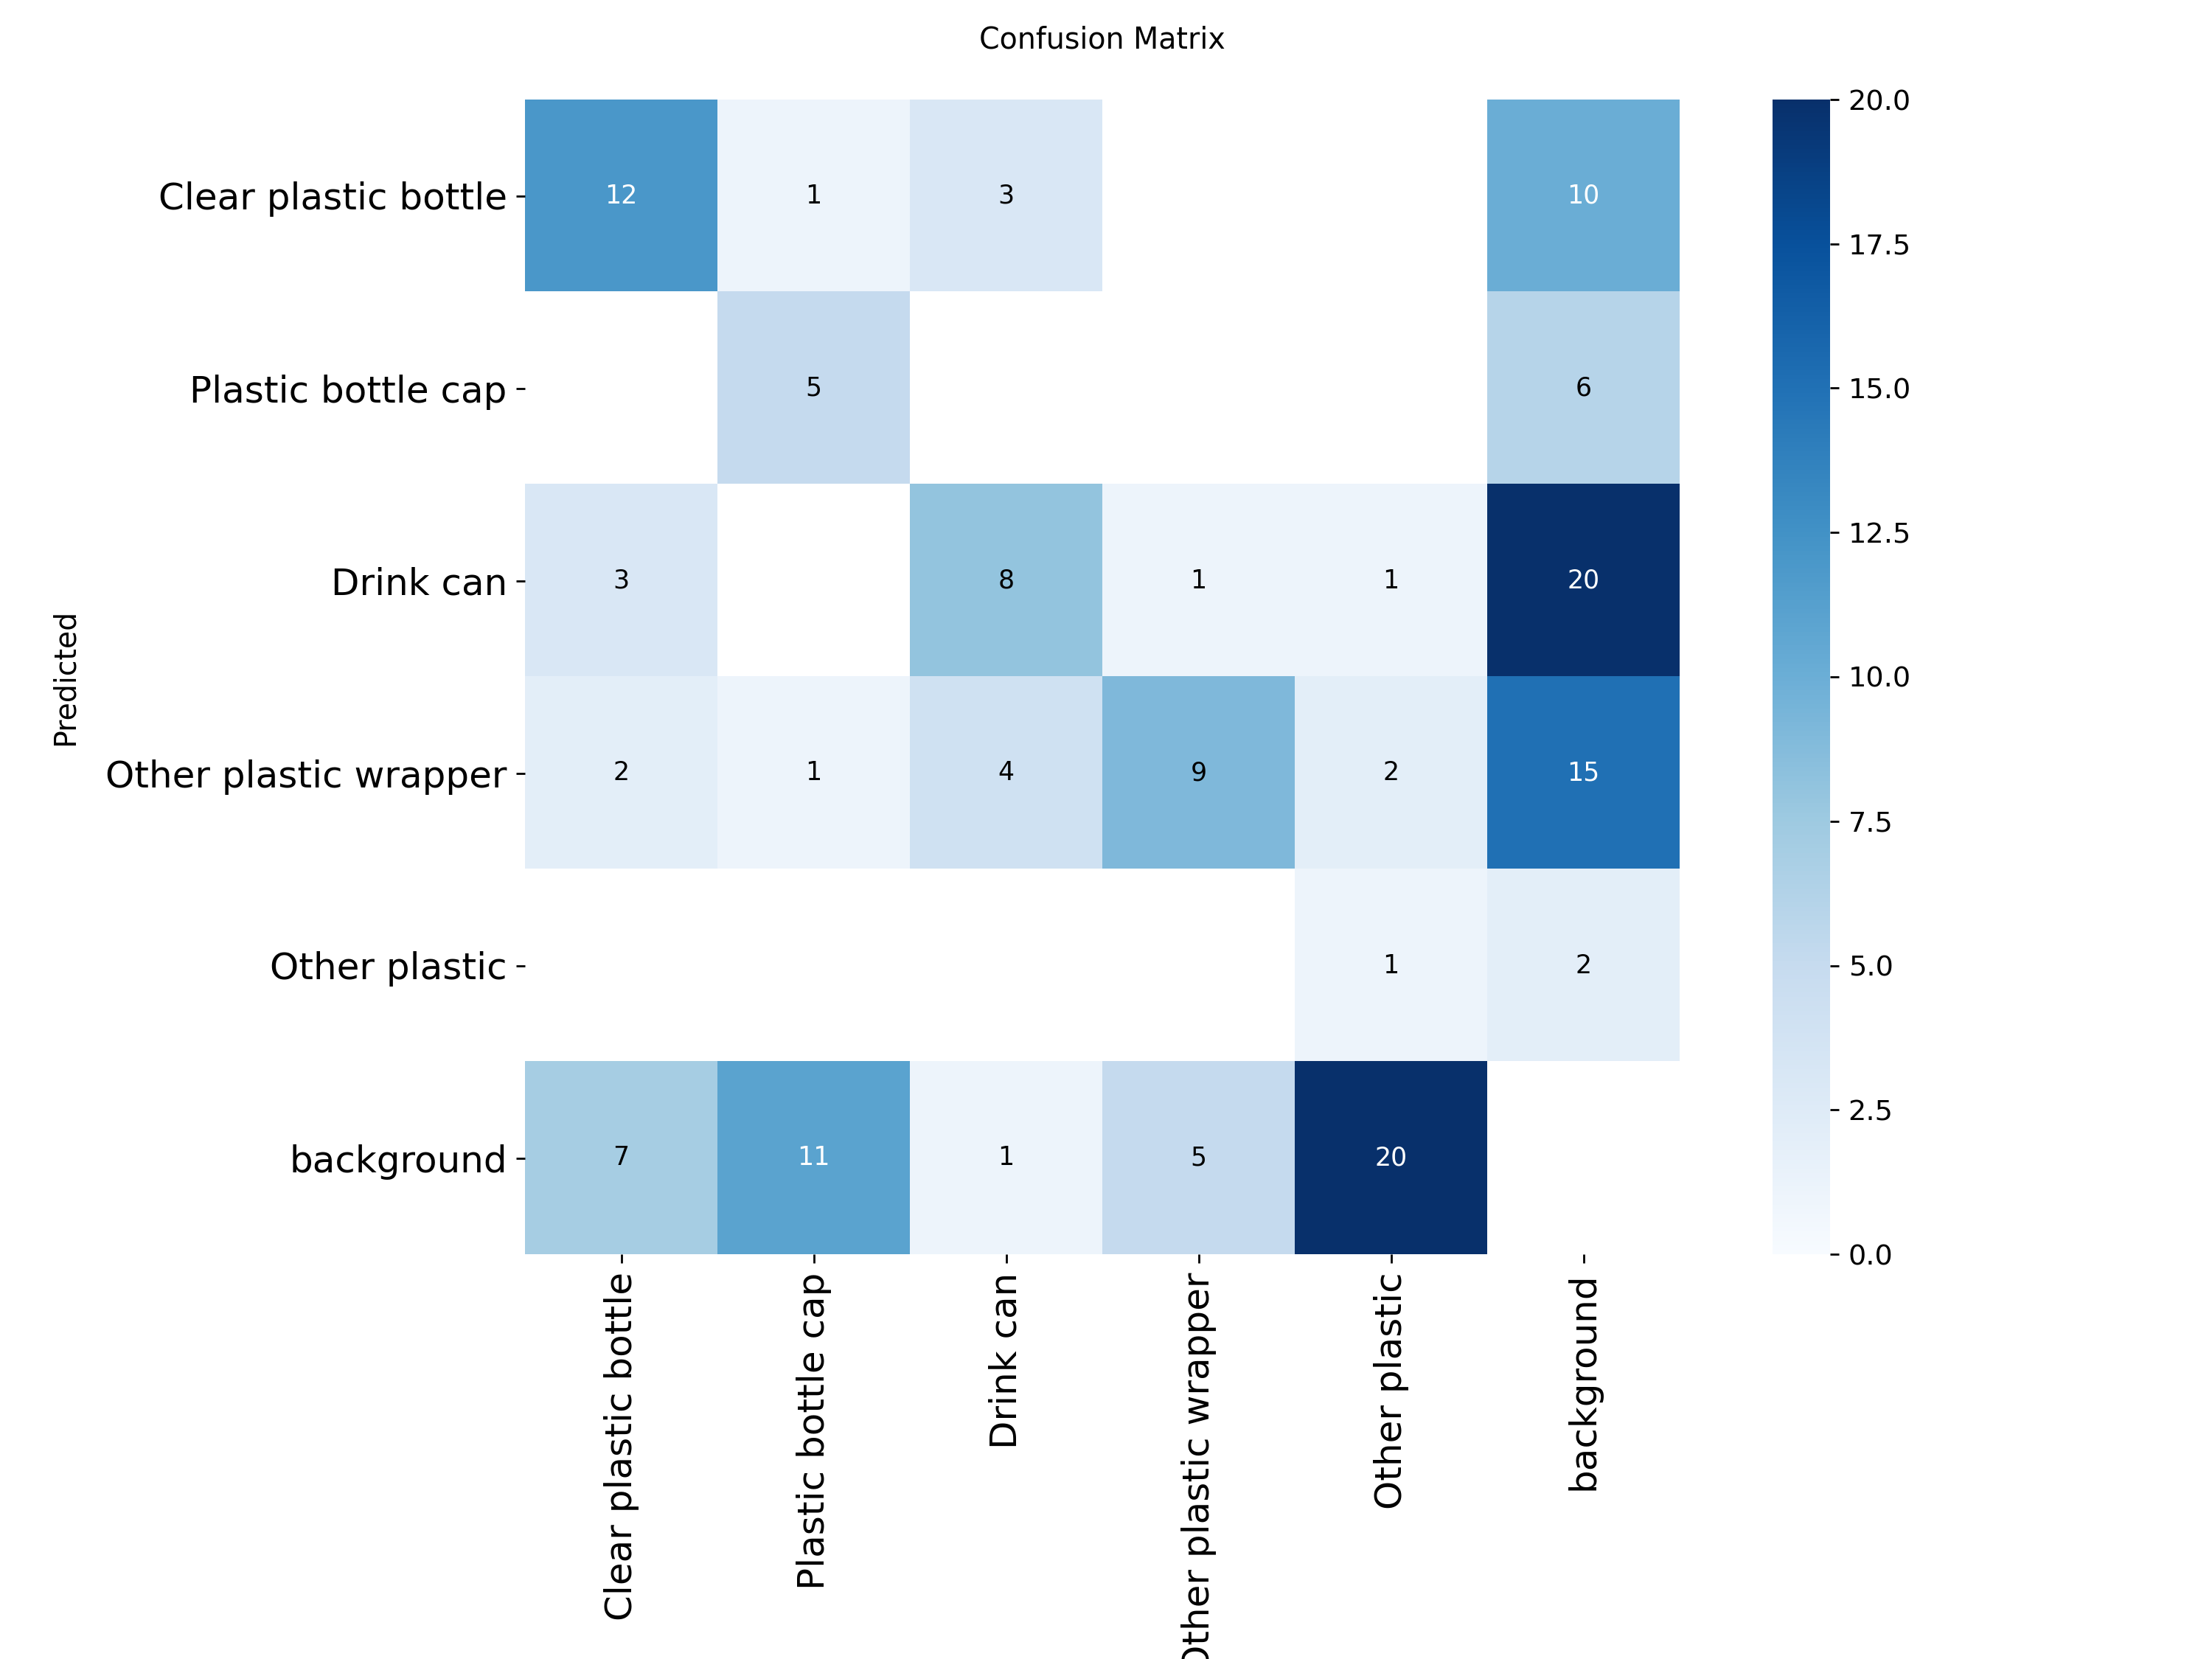

In [1]:
from IPython.display import Image
Image(filename='runs/detect/train6/confusion_matrix.png')


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los resultados
results_path = 'runs/detect/train6/results.csv'
df = pd.read_csv(results_path)

# Mostrar primeras filas para entender las columnas
print(df.head())


   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   50.8197         0.94000         1.35328         1.07912   
1      2   98.2023         0.86727         1.10795         1.06473   
2      3  143.7100         0.84971         1.14254         1.05040   
3      4  188.0360         0.80724         1.02689         1.01999   
4      5  234.2190         0.82767         0.97913         1.04506   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.66935            0.32083           0.34563   
1               0.45397            0.39508           0.39786   
2               0.51839            0.34534           0.39941   
3               0.61894            0.39754           0.49043   
4               0.45206            0.34750           0.43544   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.27661       1.19304       3.97914       1.34444  0.090148   
1              0.33297       1.06598  

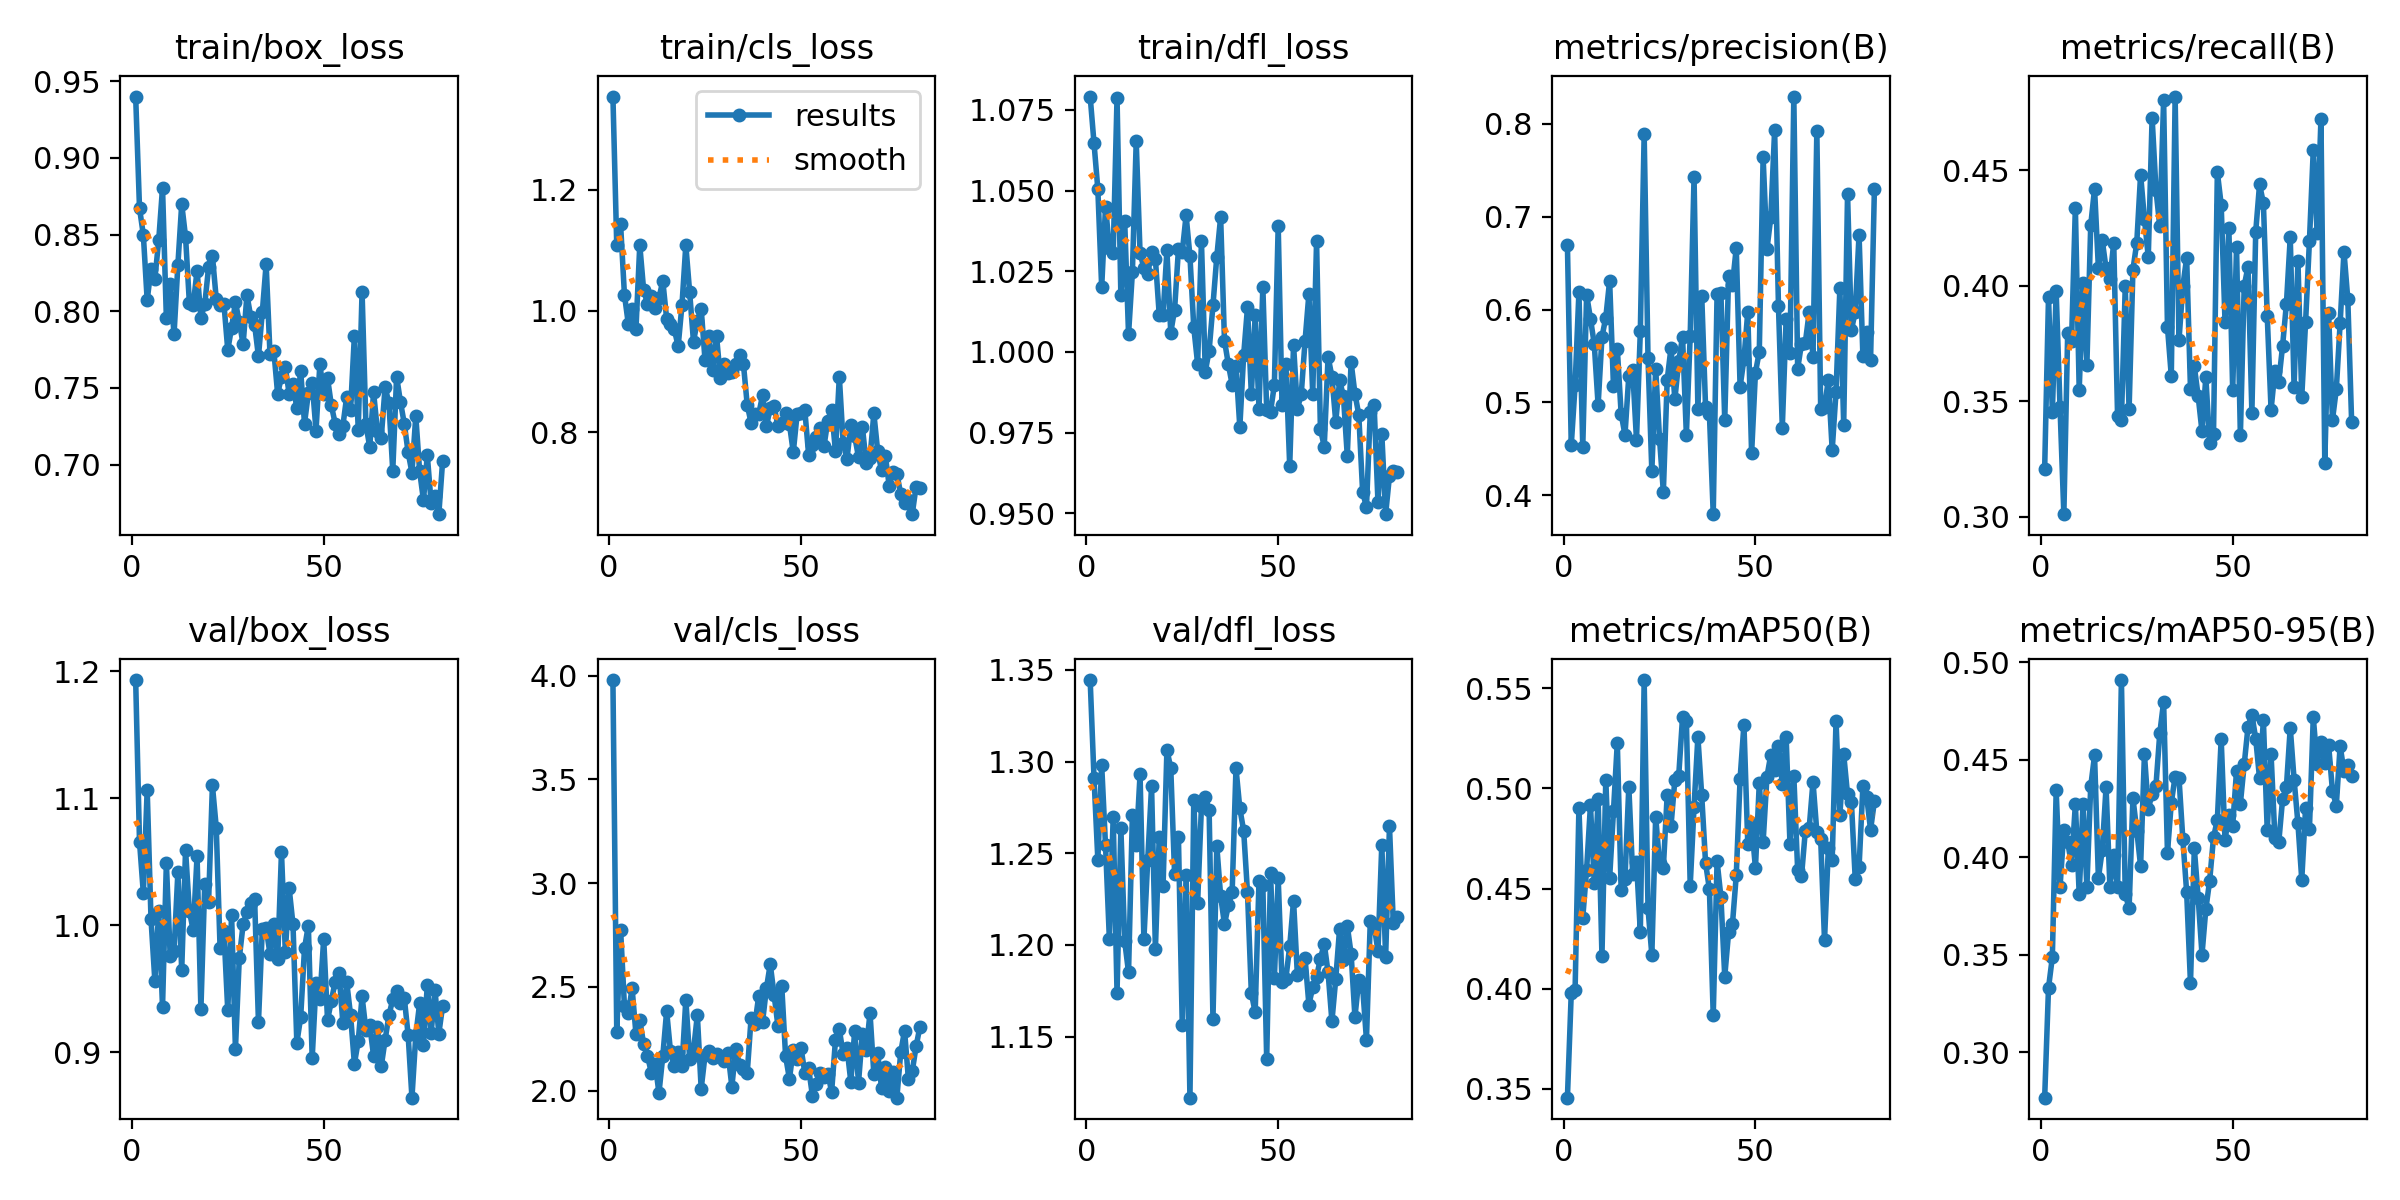

In [6]:
Image(filename='runs/detect/train6/results.png')


### F1-Confidence Curve

acontinuación graficamos el F1-Confidence Curve (curva F1 vs. Umbral de Confianza). Muestra cómo el F1-score (medida de precisión y recall balanceada) varía al ajustar el umbral de confianza del detector (de 0 a 1)

- Clear plastic bottle:  El modelo detecta bien botellas plásticas transparentes incluso con umbrales altos. Es la categoría más robusta.
- Plastic bottle cap: El modelo tiene dificultad para detectar tapas de botellas
- Drink can: Mejora alrededor del umbral 0.6
- Other plastic wrapper: Mejora con umbrales moderados (0.6–0.7)
- Other plastic: El peor resultado. Indica que el modelo no distingue bien este tipo de plástico

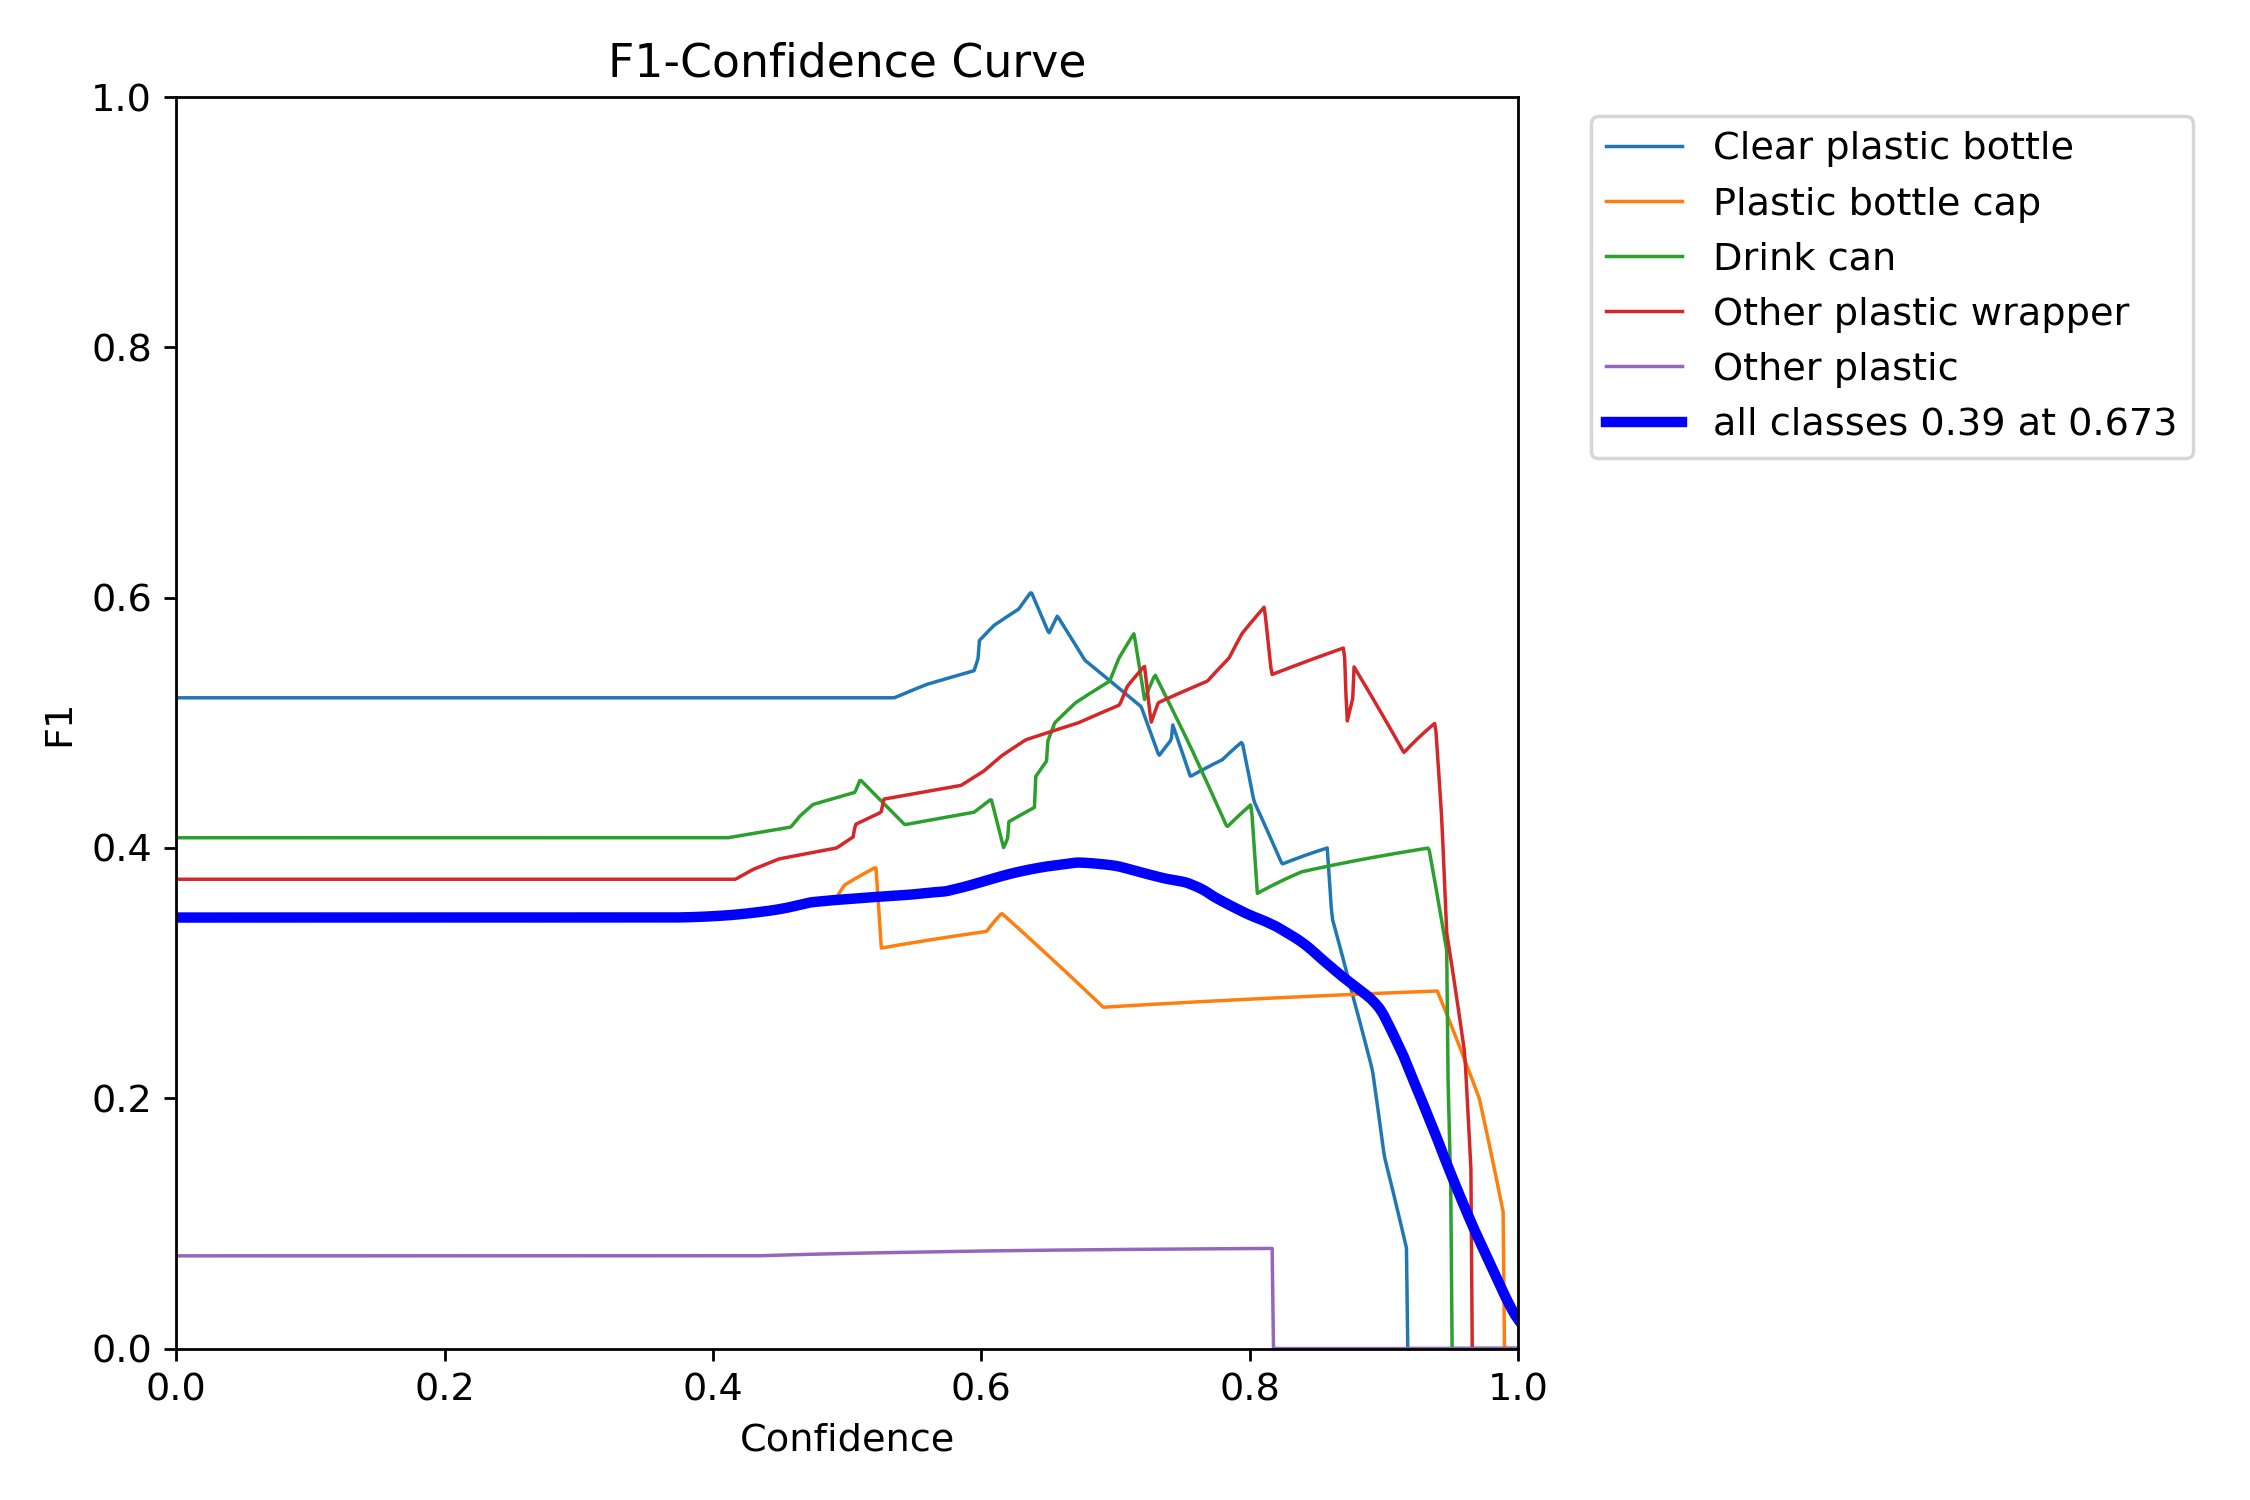

In [ ]:
Image(filename='runs/detect/train6/BoxF1_curve.png')


- Clear plastic bottle
- Plastic bottle cap
- Drink can
- Other plastic
- Other plastic wrapper


### Ejemplo en la detección de objetos de avaluación 

#### Img original con bounding boxes

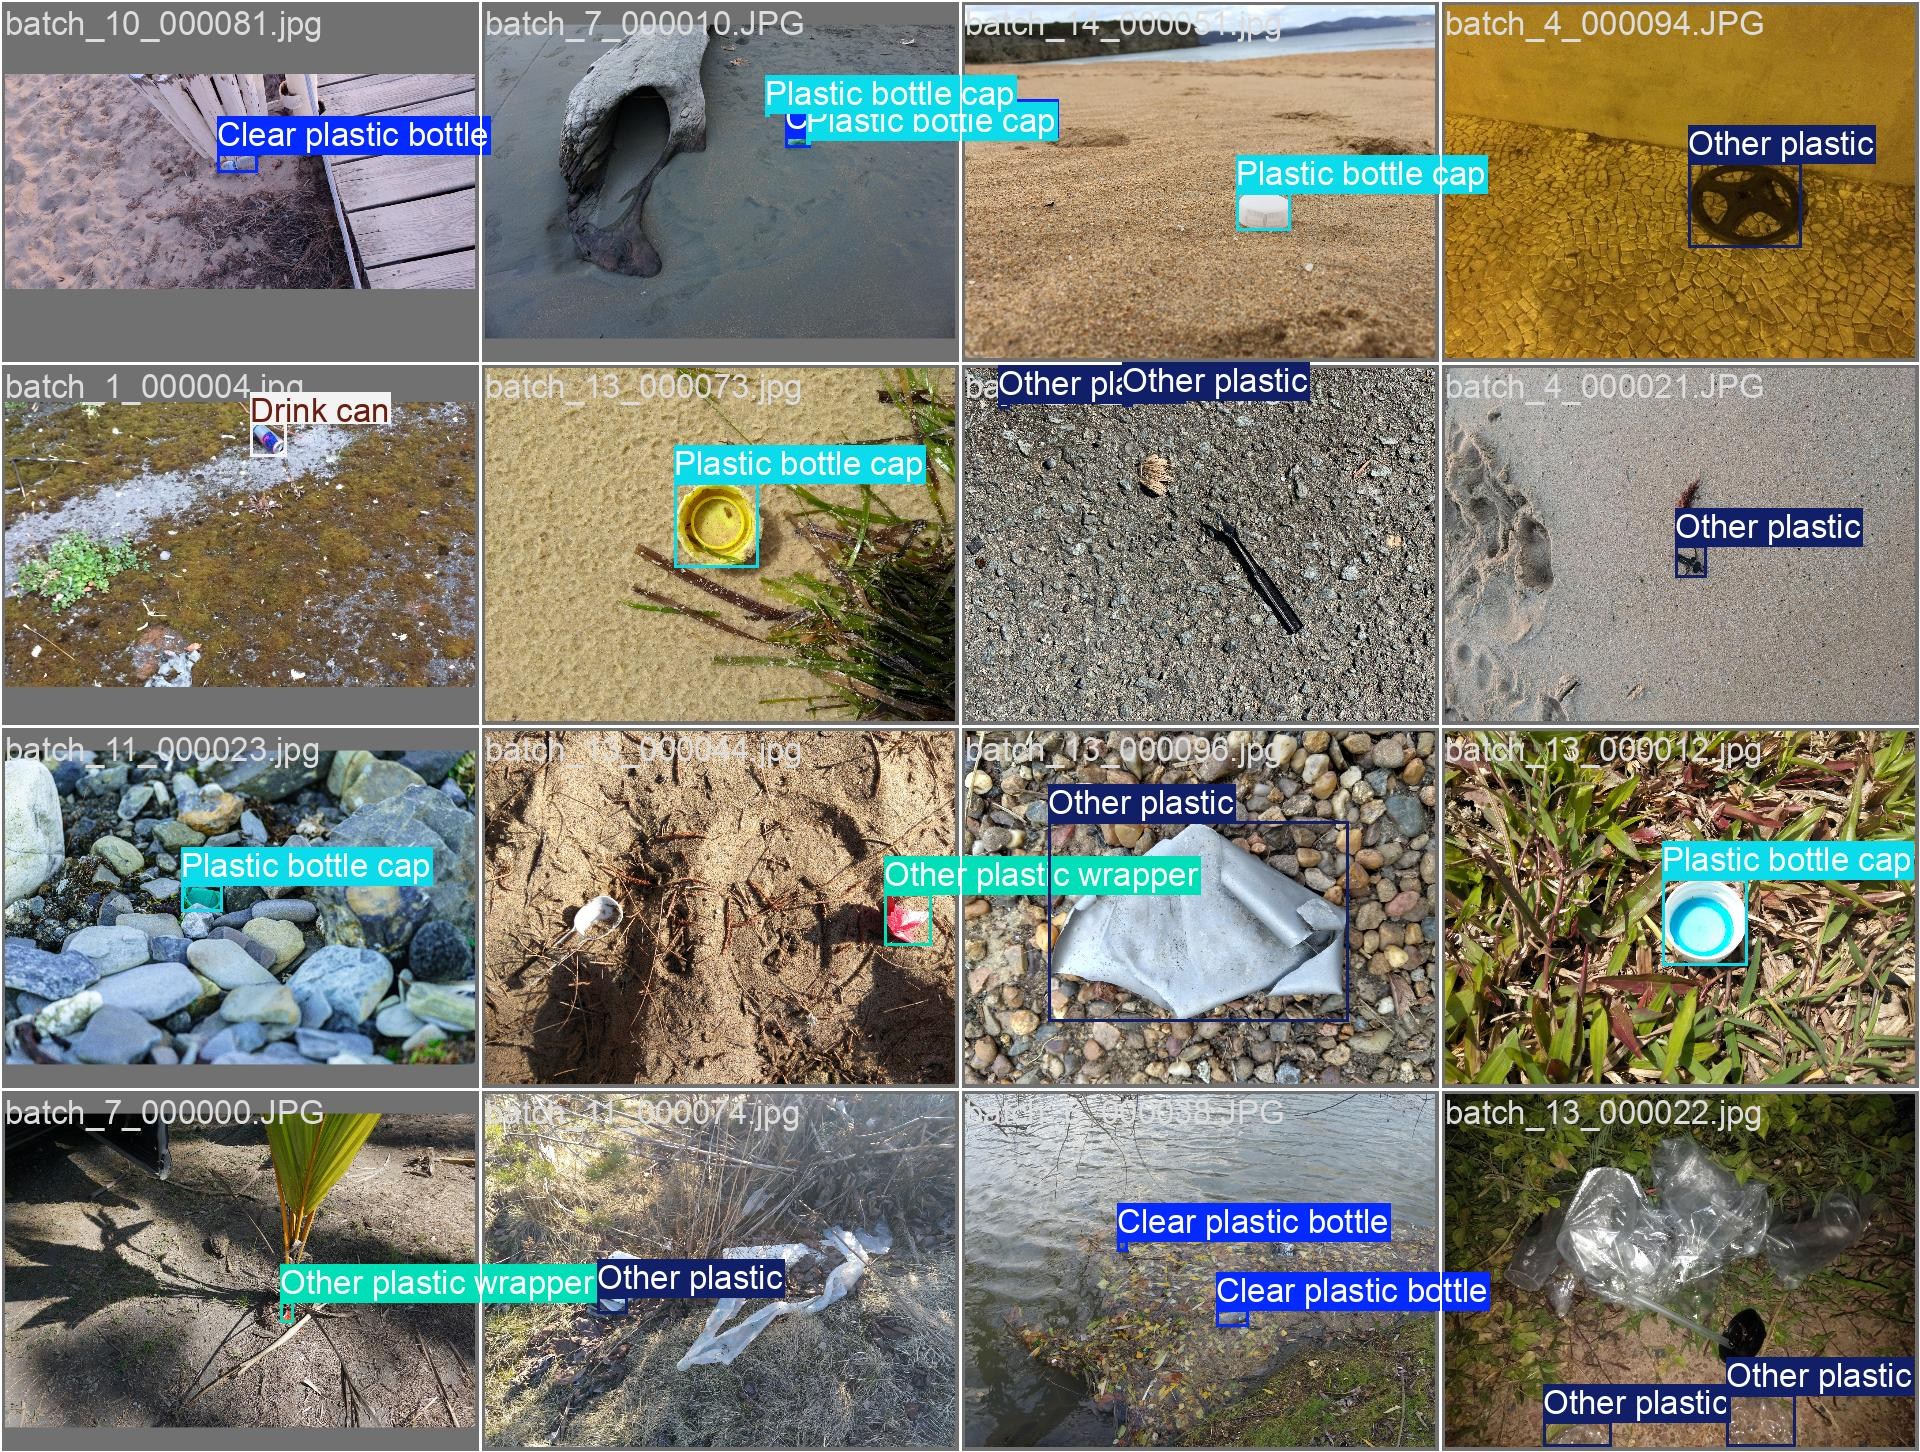

In [ ]:
Image(filename='runs/detect/train6/val_batch0_labels.jpg')

#### Img img predict - detección

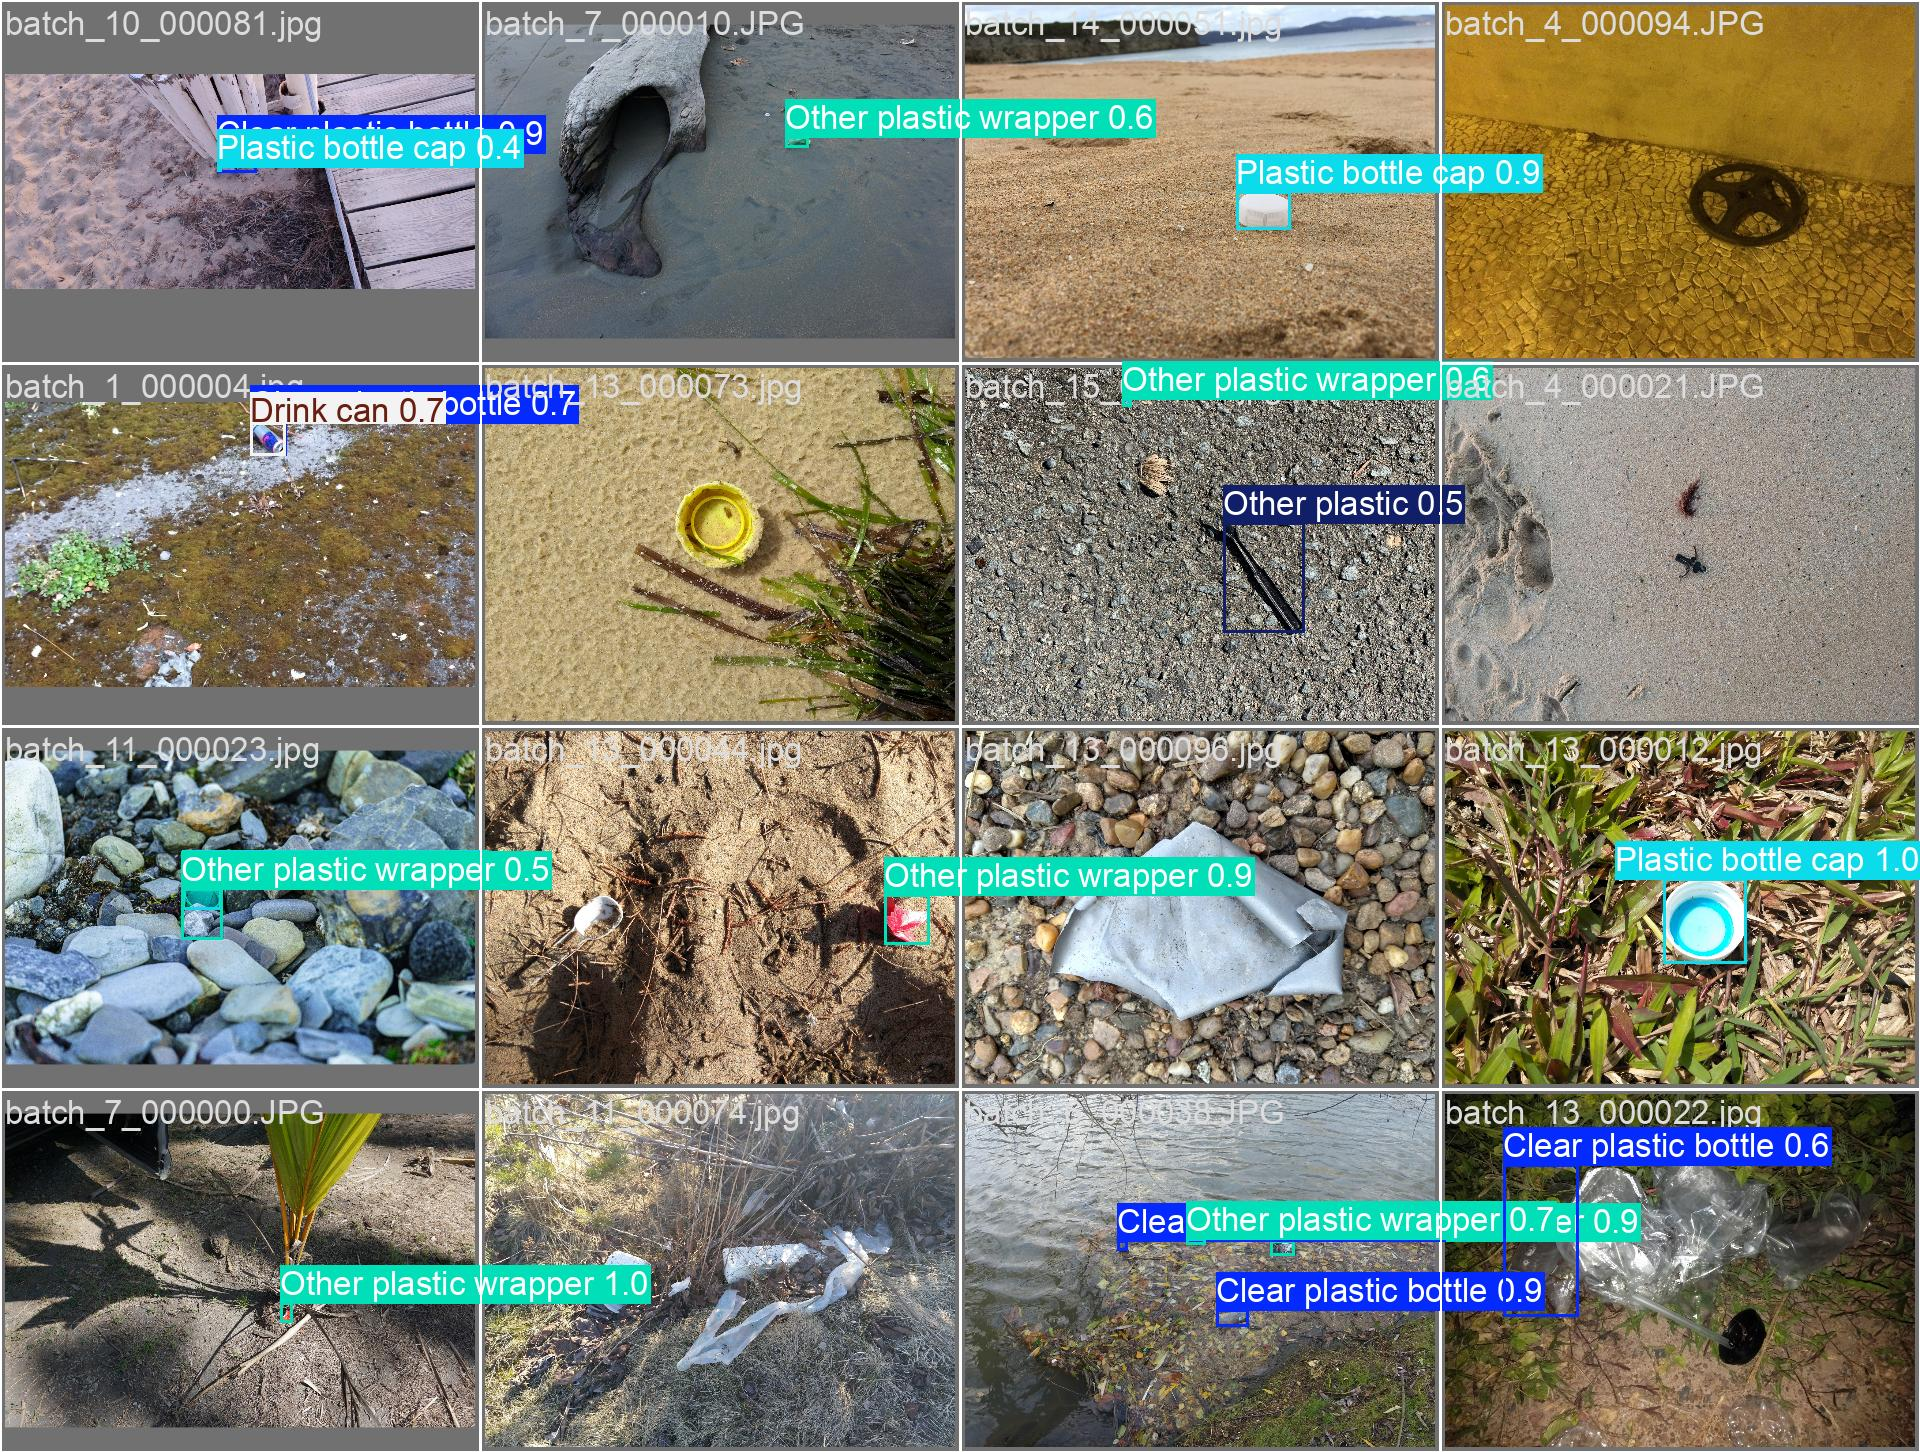

In [10]:
Image(filename='runs/detect/train6/val_batch0_pred.jpg')